# Preliminary Data Exploration

In [ ]:
import datetime
now = datetime.datetime.now()
print(f'Version: {now.strftime("%Y-%m-%d %H:%M:%S")}')

# Data Exploration

In [ ]:
import pandas as pd
import os

csv_path = './data/preprocessed_d1d2.csv'
df = pd.read_csv(csv_path)
df

In [ ]:
df.info()

In [3]:
df['AGE_AT_EXAM']

0        74.300000
1        74.790075
2        77.267830
3        79.337645
4        79.783915
           ...    
12736    75.500000
12737    75.677960
12738    77.490418
12739    69.300000
12740    71.295893
Name: AGE_AT_EXAM, Length: 12741, dtype: float64

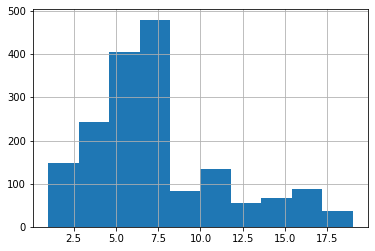

In [4]:
# visits per patient
df.groupby('RID').size().hist()

In [184]:
# n state changes
df_01 = df.dropna(subset=['target_diagnosis'])
n_state_changes = (df_01['diagnosis'] != df_01['target_diagnosis']).sum()

print(f'length of subset: {len(df_01)}')
print(f'state changes: {n_state_changes}')
print(f'state changes as frac of full dataset: {n_state_changes / len(df)}')
print(f'state changes as frac of subset: {n_state_changes / len(df_01)}')

length of subset: 7174
state changes: 3456
state changes as frac of full dataset: 0.27125029432540615
state changes as frac of subset: 0.48173961527739056


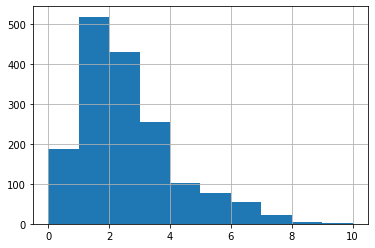

In [185]:
# state changes per patient
df_01.groupby('RID').apply(lambda x: x['diagnosis'] != x['target_diagnosis']).groupby('RID').sum().hist()

Hang on... how can there be more than 2 state changes per patient?

In [186]:
# view changes per patient for patient with RID 2
changes_per_patient = df_01.groupby('RID').apply(lambda x: x['diagnosis'] != x['target_diagnosis'])
changes_per_patient[2]

0     False
1     False
2     False
4      True
6      True
8      True
11     True
dtype: bool

In [187]:
# view patient with RID 2
df_01[temp_df['RID'] == 2][['EXAMDATE', 'DX_bl', 'DX', 'diagnosis', 'target_diagnosis']]

,EXAMDATE,DX_bl,DX,diagnosis,target_diagnosis
0,2005-09-08,CN,NL,CN,CN
1,2006-03-06,CN,NL,CN,CN
2,2008-08-27,CN,NL,CN,CN
4,2011-03-04,CN,NaN,NaN,CN
6,2012-03-22,CN,NaN,NaN,MCI
8,2013-03-25,CN,NaN,NaN,CN
11,2014-10-13,CN,NaN,NaN,CN


Oh... theres a load of Nans in the original diagnosis!

So what if we drop the NaNs in diagnosis as well?

In [188]:
# n state changes
df_02 = df.dropna(subset=['diagnosis', 'target_diagnosis']) # drop both this time
n_state_changes = (df_02['diagnosis'] != df_02['target_diagnosis']).sum()

print(f'length of subset: {len(df_02)}')
print(f'state changes: {n_state_changes}')
print(f'state changes as frac of full dataset: {n_state_changes / len(df)}')
print(f'state changes as frac of subset: {n_state_changes / len(df_02)}')

length of subset: 4053
state changes: 335
state changes as frac of full dataset: 0.026293069617769407
state changes as frac of subset: 0.08265482358746608


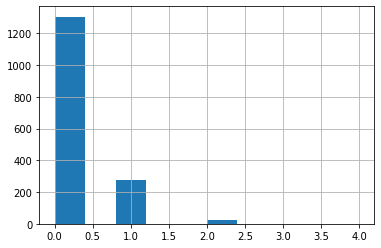

In [189]:
# state changes per patient
df_02.groupby('RID').apply(lambda x: x['diagnosis'] != x['target_diagnosis']).groupby('RID').sum().hist()

This looks a bit better I guess...

In [190]:
# view changes per patient for patient with RID 2
changes_per_patient = df_02.groupby('RID').apply(lambda x: x['diagnosis'] != x['target_diagnosis'])
changes_per_patient[2]

0    False
1    False
2    False
dtype: bool

In [191]:
# view patient with RID 2
df_02[temp_df_02['RID'] == 2][['EXAMDATE', 'DX_bl', 'DX', 'diagnosis', 'target_diagnosis']]

,EXAMDATE,DX_bl,DX,diagnosis,target_diagnosis
0,2005-09-08,CN,NL,CN,CN
1,2006-03-06,CN,NL,CN,CN
2,2008-08-27,CN,NL,CN,CN


But now theres so few state changes.

If between visits the diagnosis doesn't change, but theres a NaN, can we fill it?

In [192]:
# fill NaN in diagnosis

df_03 = df.loc[:, ['RID', 'AGE_AT_EXAM', 'DX_bl', 'DX', 'diagnosis', 'target_diagnosis']].sort_values(by=['RID', 'AGE_AT_EXAM'])
df_03

,RID,AGE_AT_EXAM,DX_bl,DX,diagnosis,target_diagnosis
0,2,74.300000,CN,NL,CN,CN
1,2,74.790075,CN,NL,CN,CN
2,2,77.267830,CN,NL,CN,CN
3,2,79.337645,CN,NL,CN,NaN
4,2,79.783915,CN,NaN,NaN,CN
...,...,...,...,...,...,...
12736,5295,75.500000,SMC,NL,CN,NaN
12737,5295,75.677960,SMC,NaN,NaN,CN
12738,5295,77.490418,SMC,NL,CN,NaN
12739,5296,69.300000,SMC,NL,CN,CN


In [193]:
df_03['prev_diagnosis'] = df_03.groupby('RID')['diagnosis'].shift(periods=1)
cond = df_03['target_diagnosis'] == df_03['prev_diagnosis']
df_03['temp_diagnosis'] = df_03['target_diagnosis'].where(cond, df_03['diagnosis'])
df_03

,RID,AGE_AT_EXAM,DX_bl,DX,diagnosis,target_diagnosis,prev_diagnosis,temp_diagnosis
0,2,74.300000,CN,NL,CN,CN,NaN,CN
1,2,74.790075,CN,NL,CN,CN,CN,CN
2,2,77.267830,CN,NL,CN,CN,CN,CN
3,2,79.337645,CN,NL,CN,NaN,CN,CN
4,2,79.783915,CN,NaN,NaN,CN,CN,CN
...,...,...,...,...,...,...,...,...
12736,5295,75.500000,SMC,NL,CN,NaN,NaN,CN
12737,5295,75.677960,SMC,NaN,NaN,CN,CN,CN
12738,5295,77.490418,SMC,NL,CN,NaN,NaN,CN
12739,5296,69.300000,SMC,NL,CN,CN,NaN,CN


In [194]:
print(f"no. filled diagnosis values: {df_03['diagnosis'].isna().sum() - df_03['temp_diagnosis'].isna().sum()}")

no. filled diagnosis values: 2840


Woah thats a lot of filled values!

In [196]:
df_04 = df_03.dropna(subset=['target_diagnosis', 'temp_diagnosis'])
n_state_changes = (df_04['temp_diagnosis'] != df_04['target_diagnosis']).sum()

print(f'length of subset: {len(df_04)}')
print(f'state changes: {n_state_changes}')
print(f'state changes as frac of full dataset: {n_state_changes / len(df)}')
print(f'state changes as frac of subset: {n_state_changes / len(df_04)}')

length of subset: 6893
state changes: 321
state changes as frac of full dataset: 0.02519425476807158
state changes as frac of subset: 0.046568983026258524


In [199]:
df_04['target_diagnosis'].isna().sum()

0

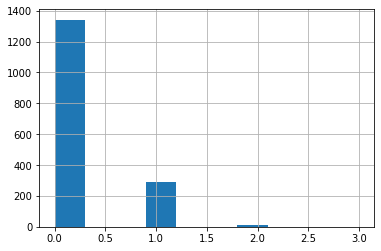

In [200]:
# state changes per patient
df_04.groupby('RID').apply(lambda x: x['temp_diagnosis'] != x['target_diagnosis']).groupby('RID').sum().hist()

# Filling in the NaNs in the og df

In [204]:
df = df.sort_values(by=['RID', 'AGE_AT_EXAM'])
df['prev_diagnosis'] = df.groupby('RID')['diagnosis'].shift(periods=1)
cond = df['target_diagnosis'] == df['prev_diagnosis']
df['diagnosis'] = df['target_diagnosis'].where(cond, df['diagnosis'])

## Examining the NaNs

Lets visualise the null values.

In [213]:
# these are the suggested biomarkers for those unfamilier with ADNI data
# according to https://tadpole.grand-challenge.org/Data/
features = {
    'dataset': ['RID'],
    # 'dataset': ['RID', 'D1', 'D2'],
    'prediction': ['diagnosis', 'ADAS13', 'Ventricles'],
    'cognitive_tests': ['CDRSB', 'ADAS11', 'MMSE', 'RAVLT_immediate'],
    'mri': ['Hippocampus', 'WholeBrain', 'Entorhinal', 'MidTemp'],
#     'pet': ['FDG', 'AV45'],
#     'csf': ['ABETA_UPENNBIOMK9_04_19_17', 'TAU_UPENNBIOMK9_04_19_17', 'PTAU_UPENNBIOMK9_04_19_17'],
    'risk_factors': ['APOE4', 'AGE_AT_EXAM']
}

# make a shortcut list of the interesting columns
columns_of_interest = []
for feature_list in features.values():
    columns_of_interest += feature_list

In [207]:
# proportion of NaNs per feature
df[columns_of_interest].isnull().sum() / len(df)

RID                           0.000000
diagnosis                     0.078251
ADAS13                        0.307433
Ventricles                    0.415666
CDRSB                         0.296523
ADAS11                        0.300683
MMSE                          0.298956
RAVLT_immediate               0.306883
Hippocampus                   0.466133
WholeBrain                    0.396515
Entorhinal                    0.492269
MidTemp                       0.492269
FDG                           0.736912
AV45                          0.833765
ABETA_UPENNBIOMK9_04_19_17    0.813986
TAU_UPENNBIOMK9_04_19_17      0.814614
PTAU_UPENNBIOMK9_04_19_17     0.814928
APOE4                         0.000942
AGE_AT_EXAM                   0.000000
dtype: float64

Woah... looks like up to around 80% of the data is missing from some features!

This makes sense for the clinical features, because fewer patients would be expected to have undergone the procedures. Especially the csf procedure as its particularly invasive.

However, around 30% of the clinical diagnoses (and other target features) are missing...

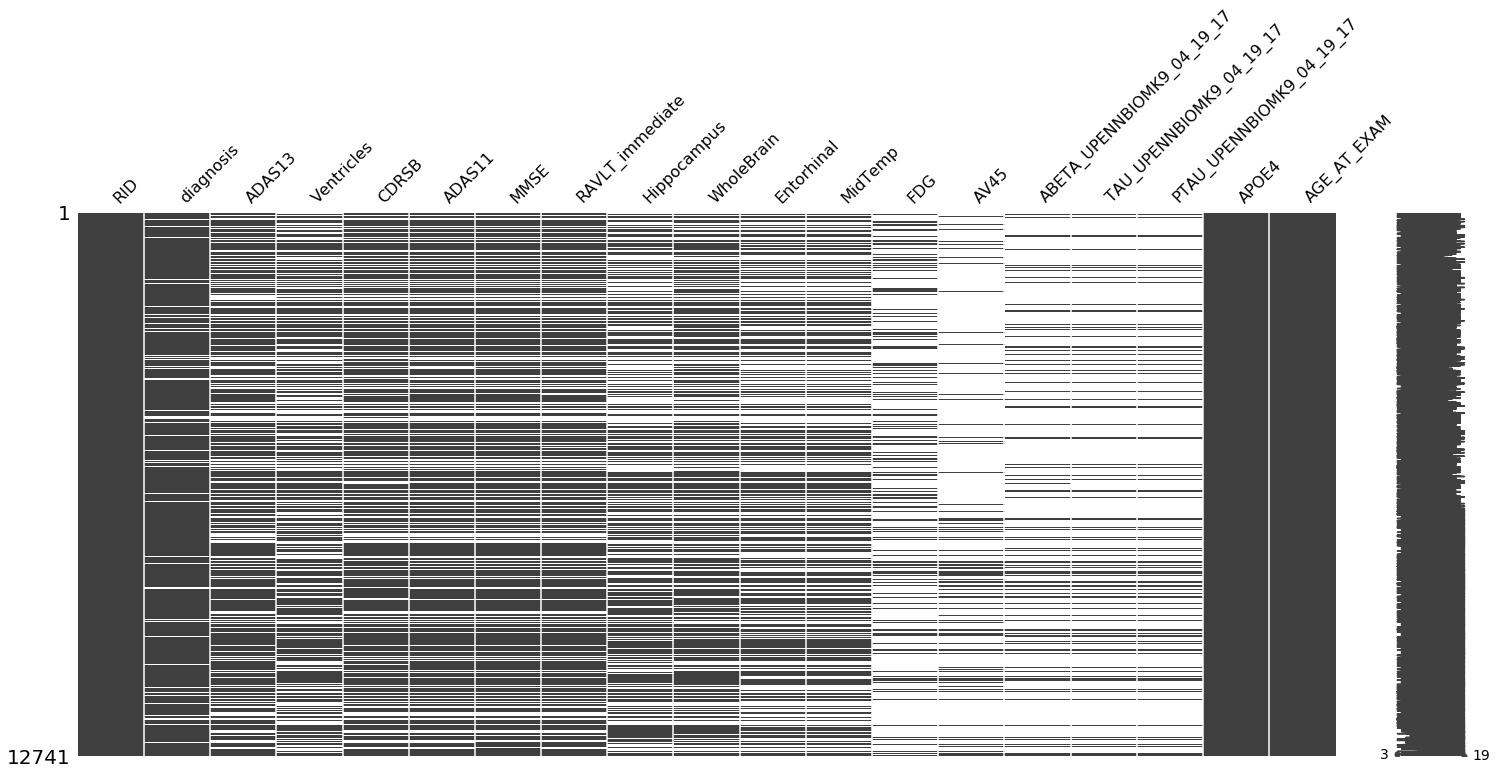

In [208]:
import missingno as msno

# This visualises the distribution of NaNs throughout 
# the dataset. Each NaN shows as a white line, and 
# each value shows as a black line.
msno.matrix(df[columns_of_interest])

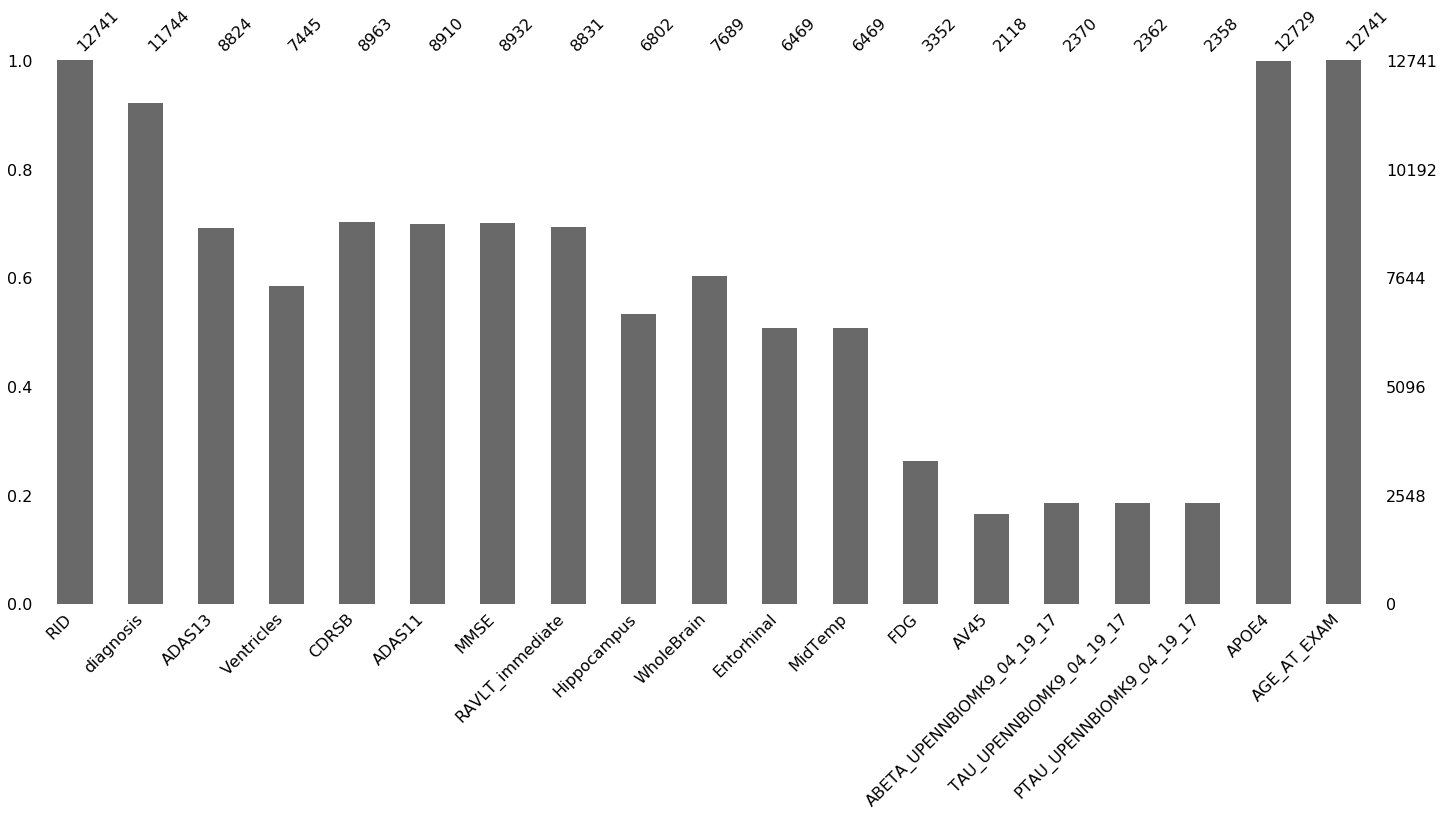

In [209]:
# Same deal as above; this is a bar chart of the number
# of values for each feature.
msno.bar(df[columns_of_interest])

Wow, we've actually filled a lot of those diagnosis values.

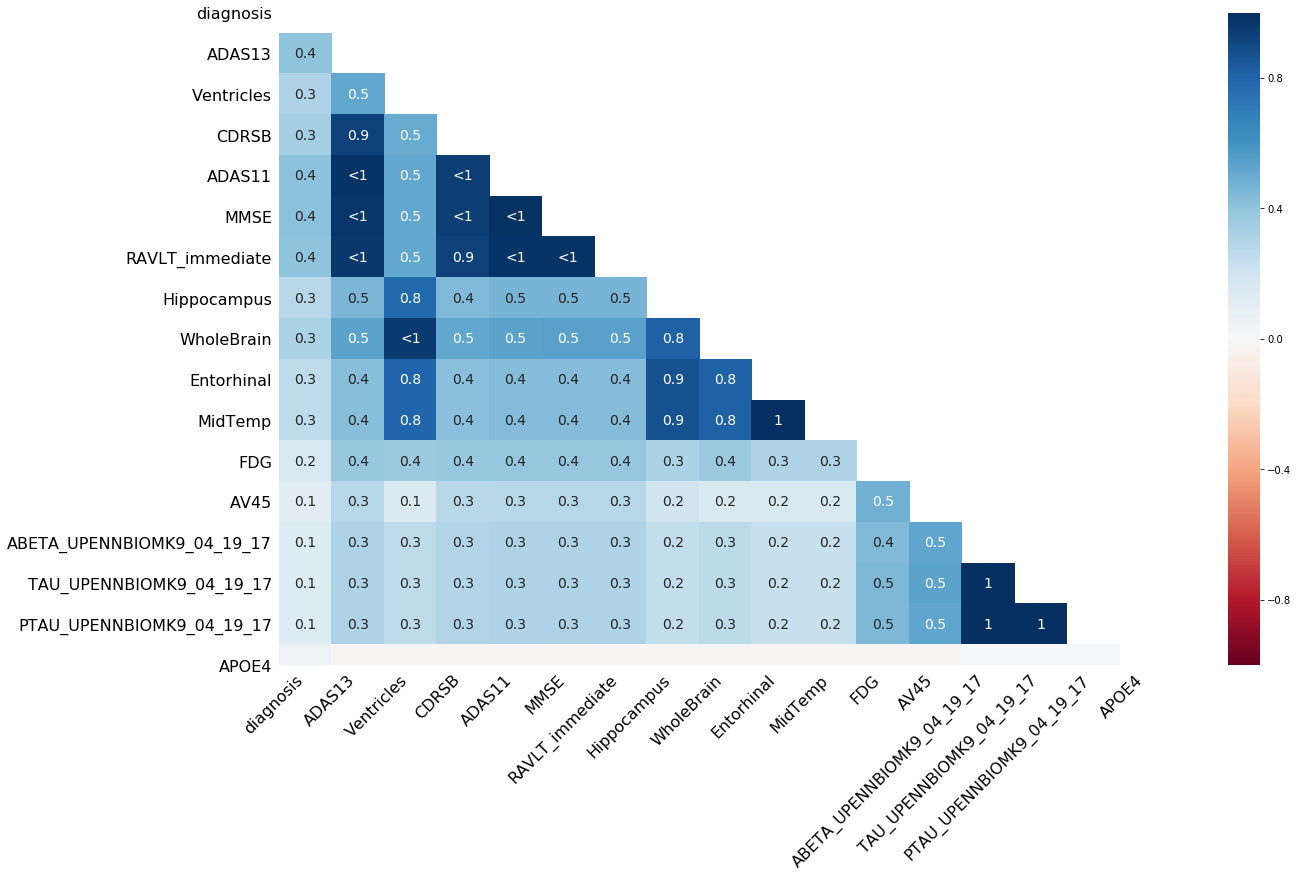

In [210]:
# A `seaborn` heatmap visualization of nullity correlation.
# 1 siginifies that if one value is missing then the other
# is likely to be missing, -1 signifies that if one value
# is present then the other is likely to be missing.
msno.heatmap(df[columns_of_interest])

In [214]:
df[columns_of_interest].dropna()

,RID,diagnosis,ADAS13,Ventricles,CDRSB,ADAS11,MMSE,RAVLT_immediate,Hippocampus,WholeBrain,Entorhinal,MidTemp,APOE4,AGE_AT_EXAM
0,2,CN,18.67,118233.0,0.0,10.67,28.0,44.0,8336.0,1229740.0,4177.0,27936.0,0.0,74.300000
13,3,AD,31.00,84599.0,4.5,22.00,20.0,22.0,5319.0,1129830.0,1791.0,18422.0,1.0,81.300000
14,3,AD,30.00,88580.0,6.0,19.00,24.0,19.0,5446.0,1100060.0,2427.0,16972.0,1.0,81.798289
15,3,AD,35.00,90099.0,3.5,24.00,17.0,31.0,5157.0,1095640.0,1596.0,17330.0,1.0,82.299316
17,3,AD,37.67,97420.0,8.0,25.67,19.0,23.0,5139.0,1088560.0,1175.0,16398.0,1.0,83.298631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12730,5290,CN,7.00,12472.0,0.0,6.00,30.0,52.0,7424.0,1010220.0,3970.0,19348.0,1.0,69.017796
12731,5292,CN,5.00,14873.0,0.0,3.00,30.0,41.0,7102.0,985330.0,3789.0,17767.0,0.0,74.300000
12733,5292,CN,5.00,17160.0,0.5,3.00,29.0,31.0,6918.0,980610.0,3791.0,17196.0,0.0,76.317796
12734,5294,CN,11.00,21884.0,0.0,8.00,30.0,49.0,8119.0,1077990.0,4498.0,21762.0,1.0,68.500000
